In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from utility import process_data, test_MA_strategy, rolling_test_MA_strategy

In [2]:
STOCK1 = "AMZN"
STOCK2 = "GOOG"


In [3]:
amzn = pd.read_csv(os.path.join('dataSent',f'{STOCK1}.csv'), sep = ",")
goog = pd.read_csv(os.path.join('dataSent',f'{STOCK2}.csv'), sep = ",")

## "Training" with Amazon

To ensure that I'm nt just overfitting. I create my strategy with Amazon and then apply it later to Google for an "out-of-sample" result. However, this is not truly accurate as presumably the Google and Amazon stocks will follow different distributions as they are different companies - but as I am only coming up with one trade strategy, this seemed a sensible way to approach the problem

In [4]:
## Does the same processing the professor does in his example notebook

amzn_cleaned, amzn_target= process_data(amzn)

In [5]:
amzn_cleaned

,Open,High,Low,Close,Adj Close,Volume,RVT,positive,negative,fearPartscr,findown,finup,finhypePartscr,certainty,uncertainty,bull,bear,bull_bear,BBr,PNlog
Date,,,,,,,,,,,,,,,,,,,,
2018-01-02,1172.000000,1190.000000,1170.510010,1189.010010,1189.010010,2694500.0,0.0031,0.0177,0.0105,0.0015,0.0040,0.0178,0.0242,0.0100,0.0106,0.015015,0.008283,0.023298,64.447592,0.003550
2018-01-03,1188.300049,1205.489990,1188.300049,1204.199951,1204.199951,3108800.0,0.0009,0.0190,0.0105,0.0018,0.0047,0.0216,0.0178,0.0091,0.0083,0.016401,0.007755,0.024156,67.896175,0.004188
2018-01-04,1205.000000,1215.869995,1204.660034,1209.589966,1209.589966,3022100.0,0.0010,0.0136,0.0226,0.0002,0.0075,0.0228,0.0121,0.0083,0.0072,0.014751,0.012309,0.027060,54.512195,-0.004420
2018-01-05,1217.510010,1229.140015,1210.000000,1229.140015,1229.140015,3544700.0,0.0015,0.0133,0.0260,0.0010,0.0065,0.0102,0.0129,0.0071,0.0069,0.010098,0.013002,0.023100,43.714286,-0.006228
2018-01-08,1236.000000,1253.079956,1232.030029,1246.869995,1246.869995,4279500.0,0.0018,0.0154,0.0174,0.0015,0.0074,0.0168,0.0166,0.0089,0.0086,0.013563,0.011022,0.024585,55.167785,-0.000984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-18,2404.350098,2433.000000,2384.010010,2426.260010,2426.260010,4366600.0,0.0005,0.0172,0.0299,0.0010,0.0194,0.0217,0.0230,0.0090,0.0134,0.015807,0.020691,0.036498,43.309222,-0.006204
2020-05-19,2429.830078,2485.000000,2428.969971,2449.330078,2449.330078,4320500.0,0.0013,0.0214,0.0224,0.0010,0.0076,0.0188,0.0158,0.0070,0.0096,0.015576,0.013068,0.028644,54.377880,-0.000489
2020-05-20,2477.870117,2500.010010,2467.270020,2497.939941,2497.939941,3998100.0,0.0015,0.0174,0.0203,0.0010,0.0084,0.0259,0.0166,0.0080,0.0099,0.016929,0.012738,0.029667,57.063404,-0.001423


In [6]:
amzn_cleaned.Close - amzn_cleaned.Close.shift(1)

Date
2018-01-02          NaN
2018-01-03    15.189941
2018-01-04     5.390015
2018-01-05    19.550049
2018-01-08    17.729980
                ...    
2020-05-18    16.479980
2020-05-19    23.070068
2020-05-20    48.609863
2020-05-21   -51.199951
2020-05-22    -9.860107
Name: Close, Length: 602, dtype: float64

In [7]:
def my_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df_ = df.copy()
    df_["returns"] = df_["Close"] - df_["Close"].shift(1)
    df_["prev_return_direct"]= pd.Series(np.where(df_["returns"] > 0, 1, -1), index=df_.index)
    df_["BBr_change"] = amzn_cleaned.BBr - amzn_cleaned.BBr.shift(1)
    return df_


In [8]:
amzn_cleaned = my_feature_engineering(amzn_cleaned)

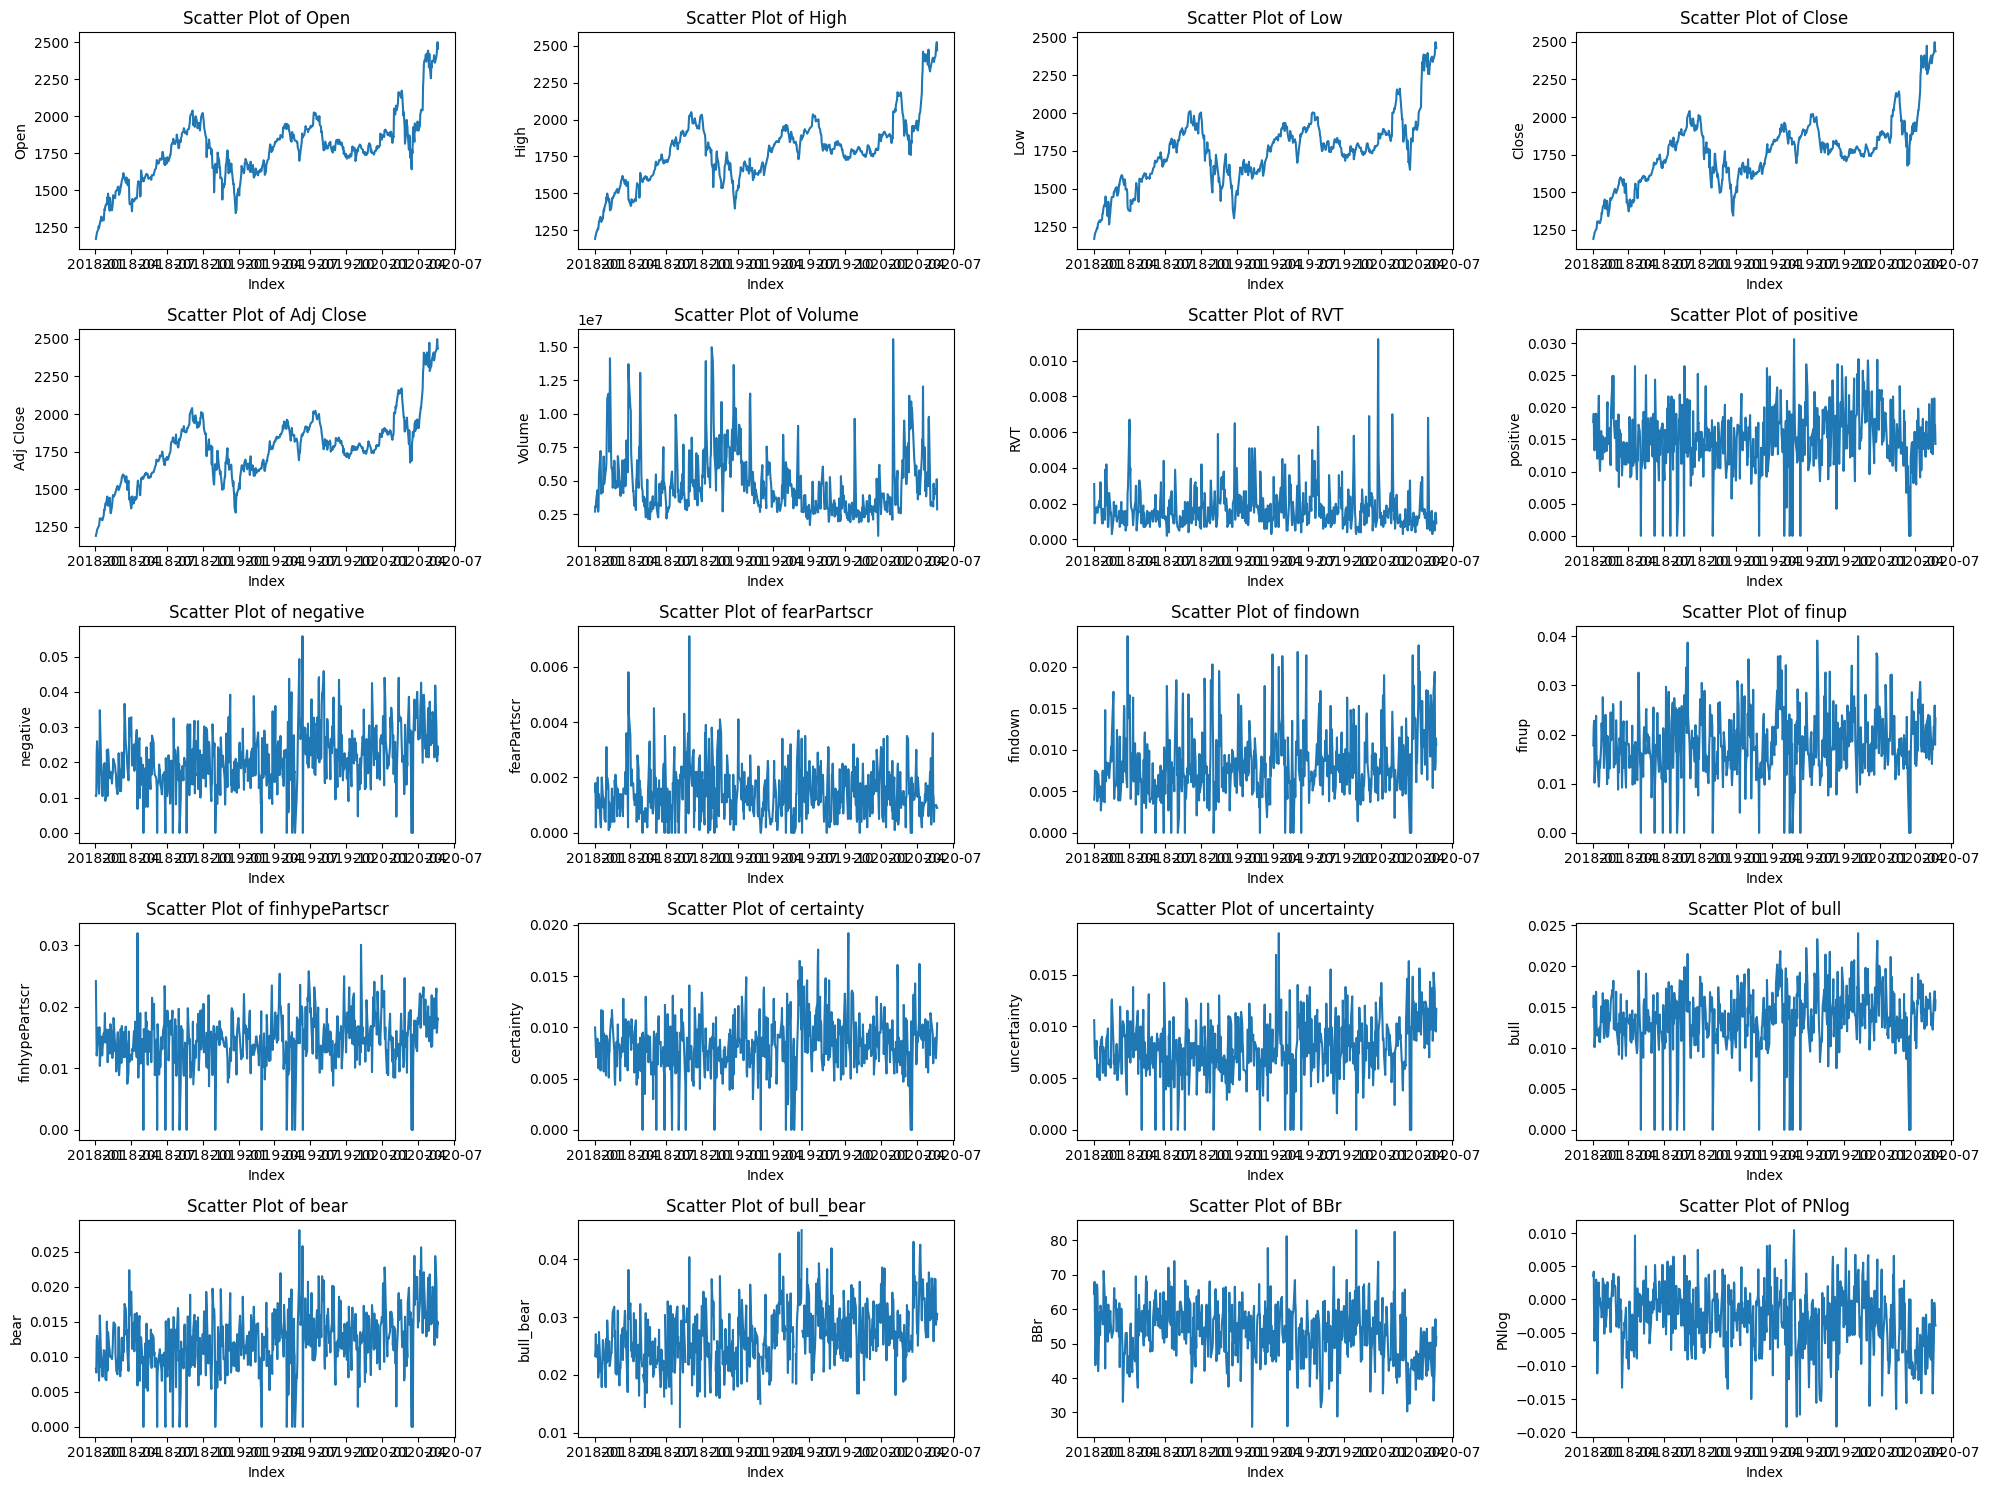

In [9]:
#plotting features
#
fig, axs = plt.subplots(5, 4, figsize=(20, 15))
axs = axs.flatten()

for i, col in enumerate(amzn_cleaned.columns):
    if i < len(axs):  # Ensure we don't exceed the number of subplots
        axs[i].plot(amzn_cleaned.index, amzn_cleaned[col])
        axs[i].set_title(f'Scatter Plot of {col}')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel(col)

plt.tight_layout()

plt.show()


[]

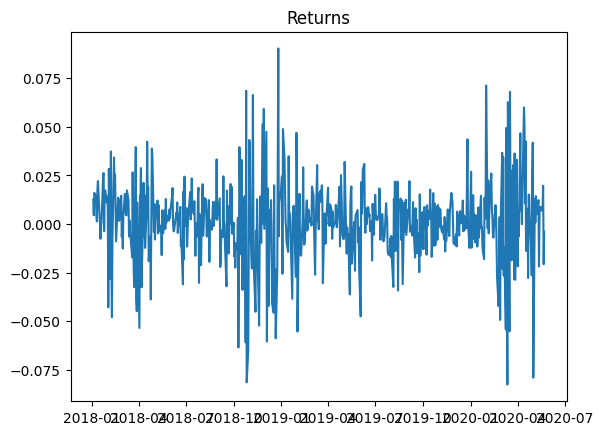

In [10]:
amzn_cleaned["returns"] = np.log(amzn_target) - np.log(amzn_target.shift(1))
plt.plot(amzn_cleaned.returns)
plt.title("Returns")
plt.plot()

In [11]:
amzn_cleaned

,Open,High,Low,Close,Adj Close,Volume,RVT,positive,negative,fearPartscr,...,certainty,uncertainty,bull,bear,bull_bear,BBr,PNlog,returns,prev_return_direct,BBr_change
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,1172.000000,1190.000000,1170.510010,1189.010010,1189.010010,2694500.0,0.0031,0.0177,0.0105,0.0015,...,0.0100,0.0106,0.015015,0.008283,0.023298,64.447592,0.003550,NaN,-1,NaN
2018-01-03,1188.300049,1205.489990,1188.300049,1204.199951,1204.199951,3108800.0,0.0009,0.0190,0.0105,0.0018,...,0.0091,0.0083,0.016401,0.007755,0.024156,67.896175,0.004188,0.012694,1,3.448583
2018-01-04,1205.000000,1215.869995,1204.660034,1209.589966,1209.589966,3022100.0,0.0010,0.0136,0.0226,0.0002,...,0.0083,0.0072,0.014751,0.012309,0.027060,54.512195,-0.004420,0.004466,1,-13.383980
2018-01-05,1217.510010,1229.140015,1210.000000,1229.140015,1229.140015,3544700.0,0.0015,0.0133,0.0260,0.0010,...,0.0071,0.0069,0.010098,0.013002,0.023100,43.714286,-0.006228,0.016033,1,-10.797909
2018-01-08,1236.000000,1253.079956,1232.030029,1246.869995,1246.869995,4279500.0,0.0018,0.0154,0.0174,0.0015,...,0.0089,0.0086,0.013563,0.011022,0.024585,55.167785,-0.000984,0.014322,1,11.453500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-18,2404.350098,2433.000000,2384.010010,2426.260010,2426.260010,4366600.0,0.0005,0.0172,0.0299,0.0010,...,0.0090,0.0134,0.015807,0.020691,0.036498,43.309222,-0.006204,0.006816,1,9.885799
2020-05-19,2429.830078,2485.000000,2428.969971,2449.330078,2449.330078,4320500.0,0.0013,0.0214,0.0224,0.0010,...,0.0070,0.0096,0.015576,0.013068,0.028644,54.377880,-0.000489,0.009464,1,11.068658
2020-05-20,2477.870117,2500.010010,2467.270020,2497.939941,2497.939941,3998100.0,0.0015,0.0174,0.0203,0.0010,...,0.0080,0.0099,0.016929,0.012738,0.029667,57.063404,-0.001423,0.019652,1,2.685524


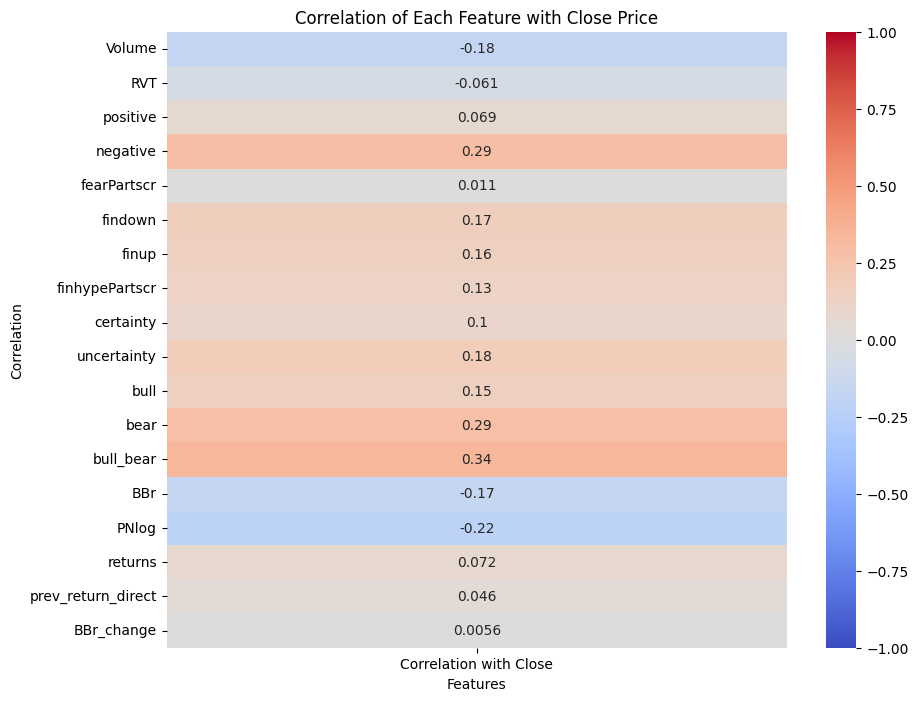

In [12]:
import seaborn as sns
subset_data = amzn_cleaned.iloc[:, 5:]

correlations = subset_data.corrwith(amzn_cleaned["Close"])

correlations_df = pd.DataFrame(correlations, columns=['Correlation with Close'])

plt.figure(figsize=(10, 8))
sns.heatmap(correlations_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation of Each Feature with Close Price')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

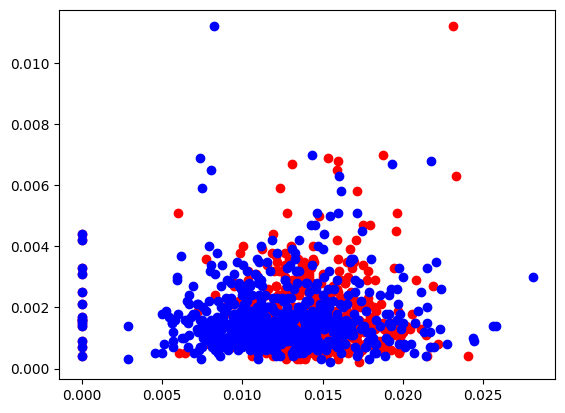

In [13]:
plt.scatter(amzn_cleaned.bull, amzn_cleaned.RVT, color = "red")
plt.scatter(amzn_cleaned.bear, amzn_cleaned.RVT, color = "blue")
plt.show()

## Playground to get my strategy

In [14]:
def get_signals(df: pd.DataFrame):
    condition1 = (df.bear > np.mean(df.bear)* 1.5) 
    condition2 = (df.PNlog > 0)
    condition3 = (abs(df.prev_return_direct.rolling(180).sum()) < 20)

    all_conditions =  condition1 | condition2 | condition3
    signal_long_only = pd.Series(
        np.where(all_conditions, 1, 0),
        index=df.index
        ).shift(1)

    signal_short = pd.Series(
        np.where(all_conditions, 1, -1),
        index=df.index
    ).shift(1)
    
    return signal_long_only, signal_short

In [15]:
signal_long_only, signal_short = get_signals(amzn_cleaned)

/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

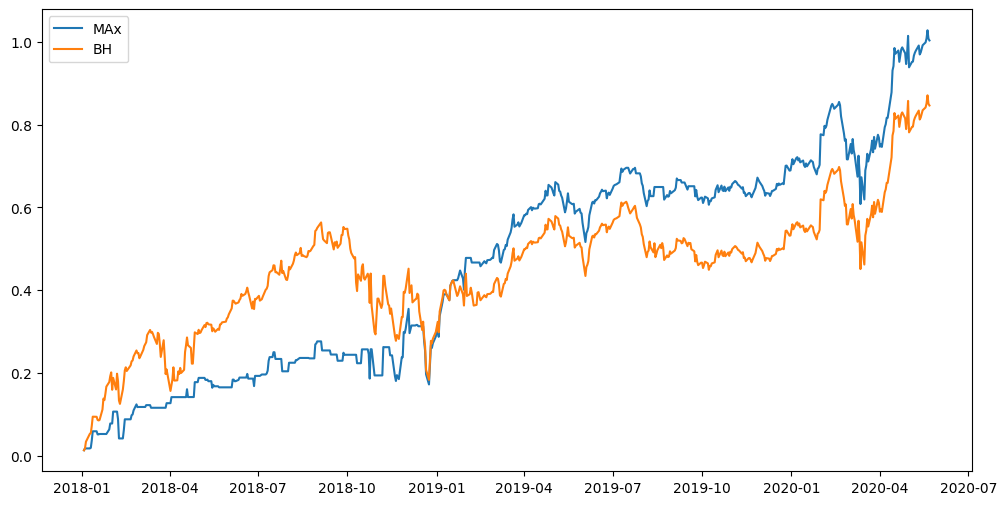

,MAx,BH
Cumulative Return,1.003240,0.846049
Annual Return,0.338188,0.293112
Annualized Sharpe Ratio,307.848656,225.328029
Win %,0.574879,0.561667
Annualized Volatility,0.276835,0.327807
Maximum Drawdown,-1.014992,-0.857801
Max Length Drawdown,0.000000,0.000000
n.trades,124.000000,2.000000


In [16]:
res, sig = test_MA_strategy(amzn_target, sig = signal_long_only)
res

# Results

## Amazon

In [17]:
amzn_cleaned, amzn_target = process_data(amzn)
amzn_cleaned = my_feature_engineering(amzn_cleaned)
signal_long_only, signal_short = get_signals(amzn_cleaned)

/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

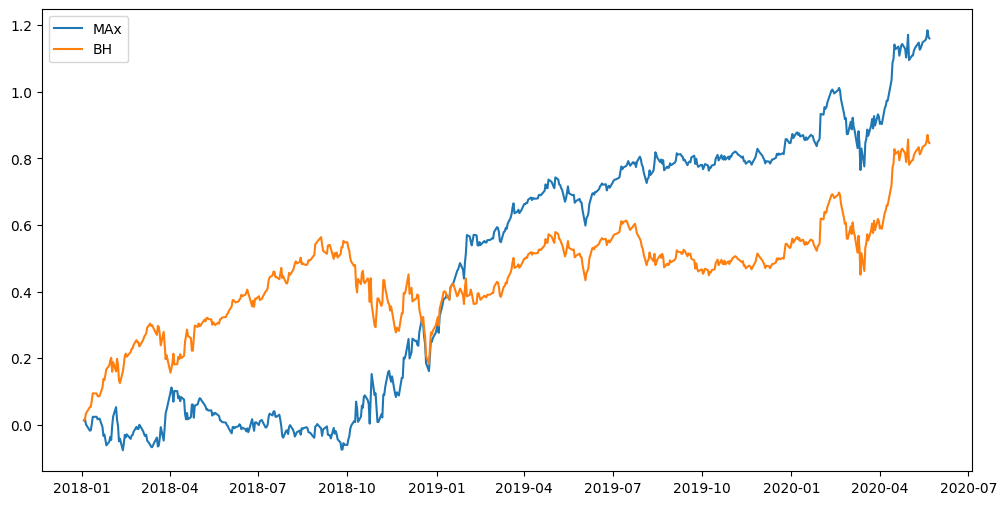

Without Trading Costs
                                MAx          BH
Cumulative Return          1.160431    0.846049
Annual Return              0.381253    0.293112
Annualized Sharpe Ratio  293.688787  225.328029
Win %                      0.541667    0.561667
Annualized Volatility      0.327134    0.327807
Maximum Drawdown          -1.261900   -0.857801
Max Length Drawdown        0.000000    0.000000
n.trades                 124.000000    2.000000

With Trading Costs
                                MAx          BH
Cumulative Return         -0.079569    0.826049
Annual Return             -0.034168    0.287219
Annualized Sharpe Ratio  -26.320738  220.797985
Win %                      0.541667    0.561667
Annualized Volatility      0.327134    0.327807
Maximum Drawdown          -1.261900   -0.857801
Max Length Drawdown        0.000000    0.000000
n.trades                 124.000000    2.000000


/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

In [20]:
res, sig = test_MA_strategy(amzn_target, sig = signal_short)
print("Without Trading Costs")
print(res)
print("")
print("With Trading Costs")
res, sig = test_MA_strategy(amzn_target, sig = signal_short, tcost = 0.01, plot = False)
print(res)

In [25]:
print(rolling_test_MA_strategy(amzn_target, sig = signal_short))
print(rolling_test_MA_strategy(amzn_target, sig = signal_long_only))

{'AvgPerf':      AvgPerf
BH  0.000655
Me  0.002343, 'NumWindows': 349}
{'AvgPerf':      AvgPerf
BH  0.000655
Me  0.001499, 'NumWindows': 349}


## Google

In [26]:
goog_cleaned, goog_target = process_data(goog)
goog_cleaned = my_feature_engineering(goog_cleaned)
signal_long_only, signal_short = get_signals(goog_cleaned)

/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

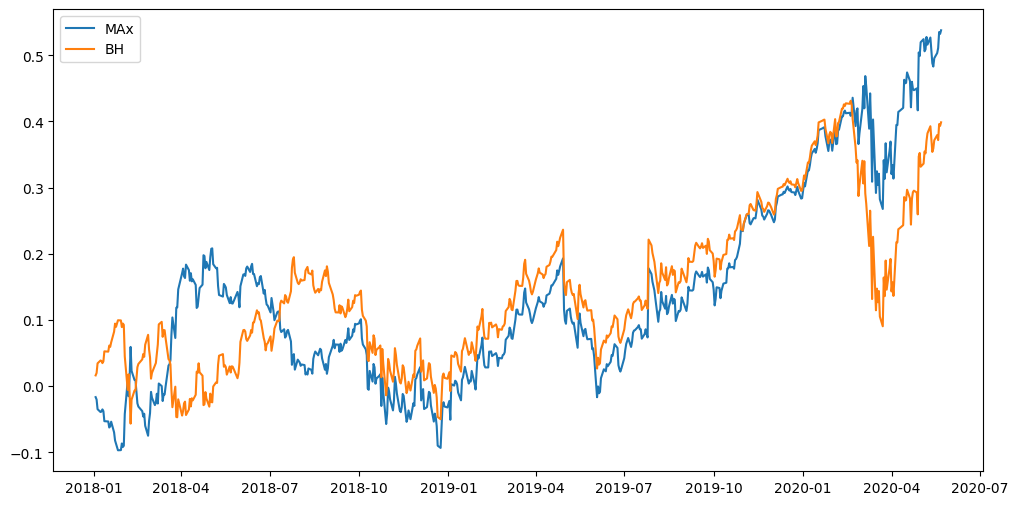

Without Trading Costs
                                MAx          BH
Cumulative Return          0.537778    0.398745
Annual Return              0.197746    0.151087
Annualized Sharpe Ratio  158.644611  121.156255
Win %                      0.522463    0.535774
Annualized Volatility      0.314111    0.314256
Maximum Drawdown          -0.634488   -0.487803
Max Length Drawdown        0.000000    0.000000
n.trades                  75.000000    2.000000

With Trading Costs
                               MAx          BH
Cumulative Return        -0.212222    0.378745
Annual Return            -0.095180    0.144157
Annualized Sharpe Ratio -76.359765  115.599053
Win %                     0.522463    0.535774
Annualized Volatility     0.314111    0.314256
Maximum Drawdown         -0.634488   -0.487803
Max Length Drawdown       0.000000    0.000000
n.trades                 75.000000    2.000000


/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annRetx = (np.power(cumRetx[-1] + 1, 252 / len(x)) - 1)
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Perf = np.array([cumRetx[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
/Users/joshuachen/Desktop/BSE/ml_finance/homework 2/utility.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

In [27]:
res, sig = test_MA_strategy(goog_target, sig = signal_short)
print("Without Trading Costs")
print(res)
print("")
print("With Trading Costs")
res, sig = test_MA_strategy(goog_target, sig = signal_short, tcost = 0.01, plot = False)
print(res)

In [28]:
print(rolling_test_MA_strategy(amzn_target, sig = signal_short))
print(rolling_test_MA_strategy(amzn_target, sig = signal_long_only))

{'AvgPerf':      AvgPerf
BH  0.000655
Me  0.000076, 'NumWindows': 349}
{'AvgPerf':      AvgPerf
BH  0.000655
Me  0.000366, 'NumWindows': 349}
